## Med64 Analysis
To use with CoLab notebooks, upload the data files manually. 

In [1]:
# imports for notebook not the .py file
from pprint import pprint as pprint

In [2]:
import os, re
import yaml
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
from scipy import signal, stats

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Find local data filenames ##

In [4]:
# define global file path

#DATA_DIR = 'C/Users/fieldslab2/Desktop/Lab/MatLab/MED64_Data/experiment/HB_139_DAMGO/20200825_12h24m37s'
DATA_DIR = r'C:\Users\\fieldslab2\\Desktop\\Lab\\MatLab\\MED64_Data\\experiment\\HB_139_DAMGO\\20200825_12h24m37s'

SLICE_PARAMS_FILE = 'slice_parameters.yaml'
PRODUCT_DIR = r'C:\Users\\fieldslab2\\Desktop\\Lab\\MatLab\\MED64_Data\\product\\HB_139_DAMGO\\'


In [5]:
yaml_file = os.path.join(DATA_DIR, SLICE_PARAMS_FILE)
yaml_file

'C:\\Users\\\\fieldslab2\\\\Desktop\\\\Lab\\\\MatLab\\\\MED64_Data\\\\experiment\\\\HB_139_DAMGO\\\\20200825_12h24m37s\\slice_parameters.yaml'

In [6]:
def find_expt_files(yaml_file):    
    with open(yaml_file, 'r') as file:
        med64_data = yaml.safe_load(file)

    # pprint(med64_data, sort_dicts=False, indent=4)
    
    paths = med64_data['paths']
    slice_path = os.path.join(paths['base'], paths['protocol'], paths['slice'])
    
    slice_name = paths['slice']
    tx_file = os.path.join(slice_path, paths['treatment'])
    unit_file = os.path.join(slice_path, paths['unit'])

    #  expt_list[0] now replaced with slice_name
    # tx_files now tx_file without s
    return  slice_name, tx_file, unit_file



In [7]:
expt_list, tx_files, unit_files = find_expt_files(yaml_file)

## Read datafiles ##

Note: The matlab file for the waveform is imported as a column array. To transpose the waveform array W use `np.transpose(W)[0]`

In [8]:
def extract_units_mat_data(units_mat):
    """extract timestamps into flatter structure from units_xxx.mat file"""
    TS = 0
    MWAVE = 1
    data_key = mat_data_key(units_mat)
    
    num_units = units_mat[data_key][0].shape[0]
    timestamps = dict()
    for u in range(num_units):
        timestamps[u] = dict()
        timestamps[u]['timestamps'] = np.sort(units_mat[data_key][0][u][TS][0])
        timestamps[u]['waveform'] = units_mat[data_key][0][u][MWAVE]
    return timestamps


def mat_data_key(mat_dat_object):
    """Finds first key in object besides __header__, etc."""
    object_keys = mat_dat_object.keys()
    data_keys = [k for k in object_keys if ("__" not in k)]
    if (len(data_keys) > 1):
        print("Warning: More than one data key found in Matlab file")
    return data_keys[0]


def read_units_file(unit_filename):
    units_mat = scipy.io.loadmat(unit_filename)
    return extract_units_mat_data(units_mat)

In [9]:
def get_expt_data(unit_filename, tx_filename):
    # get_expt_data(data_dir, expt_id):
    """change to use names as keys. data_dir no longer needed.
    create one large data struct with {expt_id: file_type: path}
    Then pass the entire expts_paths dict.
    """
    # unit_filename = data_dir + unit_files[expt_id]
    units_data = read_units_file(unit_filename)

    # tx_filename = data_dir + tx_files[expt_id]
    tx_times = read_tx_file(tx_filename)
    
    return units_data, tx_times

In [10]:
expt_list, tx_filename, unit_filename = find_expt_files(yaml_file)
expt_list = list(expt_list)


In [11]:
units_mat = scipy.io.loadmat(unit_filename)

In [12]:
def read_tx_file(tx_filename):
    tx_times = dict()
    with open(tx_filename) as csvDataFile:
        csvReader = csv.DictReader(csvDataFile)
        for row in csvReader:
            # print(row[' end'])
            tx_times[row[" label"]] = float(row['begin'])
    return tx_times



In [13]:
read_tx_file(tx_filename)

{' Baseline': 0.0,
 ' Start Baseline': 1.0,
 ' Start DNQX': 597.0,
 ' Start BT139': 1197.0,
 ' Stop BT139': 1617.0,
 ' Stop wash': 1918.0,
 ' Stop DAMGO': 2917.0,
 ' Start DAMGO': 2608.0,
 ' Stop TTX': 3217.0}

In [14]:
units_data, tx_times = get_expt_data(unit_filename, tx_filename)

## Rug Plots ##

In [15]:
def rug_thinning_factor(num_ts):
    """returns thinning factor for optimal visualization of rug.
    use return value as index slicing step size.
    """
    max_ts_num = 150
    if num_ts <= max_ts_num:
        return 1
    return int(num_ts / max_ts_num)

### Histogram, KDE, Rug plot

In [16]:
def get_hist_bins(timestamps, bin_sec):
    """Create bins for historgram plot using a bin duration
    of the desiganted bin_sec for number of seconds per bin.
    Returns ND array of beginning time of each bin, plus end 
    time of last bin. Starts first bin at zero.
    """
    num_bins = int(np.floor(timestamps.max() / bin_sec)) + 1
    start = 0
    stop = int(num_bins * bin_sec)
    return np.linspace(start, stop, num = (num_bins+1))

In [17]:
def plot_expt_histo(timestamps, tx_times, bin_sec):
    num_ts = timestamps.shape[0]
    bins = get_hist_bins(timestamps, bin_sec)
    max_tx = max(tx_times.values())

    fig, ax1 = plt.subplots(figsize=(8,4))
    ax2 = ax1.twinx()

    # plot kernel density
    density = stats.kde.gaussian_kde(timestamps)
    x = np.arange(timestamps.min(), timestamps.max(), 0.1)
    kde_x = density(x)
    ax2.plot(x, kde_x)
    
    # plot hist
    # N is the count in each bin, bins is the lower-limit of the bin
    counts, bin_edges = np.histogram(timestamps, bins=bins)
    N, bins, patches = ax1.hist(bins[:-1], bins=bins, weights=(counts/bin_sec), alpha=0.4)

    # plot rug
    thin_rug = rug_thinning_factor(num_ts) # improves visualization, make func
    rug_height = N.min() #kde_x.min()
    ax1.plot(timestamps[::thin_rug], [rug_height]*len(timestamps[::thin_rug]), '|', color='k');

    # plot treatment boundary times
    y_span = np.linspace(0, N.max(), num=2)

    for tx, tx_time in tx_times.items():
        ax1.plot((tx_time * np.ones(2)), y_span)
        ax1.annotate(tx, (tx_time, 0.5), rotation=90)
    
    plt.xlim(0, max_tx)

    ax1.set_ylabel('Unit Activity (Hz)')
    ax1.set_xlabel('Experiment Time (s)')
    ax2.set_ylabel('Kernel Density')
    plt.show()

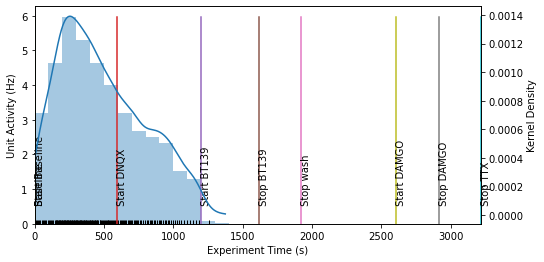

In [18]:
UNIT = 0
timestamps = units_data[UNIT]['timestamps']
bin_sec = 100
plot_expt_histo(timestamps, tx_times, bin_sec)

In [19]:
def calculate_baseline(timestamps):
    """Rethink this function. Probably not necessary
    """
    last_timestamp = timestamps[-1]
    delay = 120 #replace with default delay, as many units stop firing long before TTX On 120
    if last_timestamp > tx_times[' TTX off']: #off instead of on because it could just be a long delay if it was on
        print('Not a real neuron') #note that looking at the rug plots many are not 'real', double check
        return
    elif last_timestamp > tx_times[' TTX On'] + delay: #might not be a good way, if there is a fluke as in unit 23, large delay
        delay = last_timestamp - tx_times[' TTX On']
    print('Delay: ' + str(delay))
        
    #double check that AMPA blocker is when to start
    baseline_timestamps = [t for t in timestamps if t >= tx_times[' AMPA blocker DNQX'] + delay and t < tx_times[' BT139 1uM On']]
    #remove noise because sometimes they fire once in  a while
    #read thing in matts drive
    #plot firing rate, use models where the cutoff is at different points and see how well it fits (find accurate delay)
    #boxing whisker plot for each condition (drug) where mean firing rate for each unit see if big diff
    
    return len(baseline_timestamps)/(baseline_timestamps[-1] - baseline_timestamps[0])

    '''Diagnosis code, note that most isi are <1s, but some go up to 7 seconds, should I remove anomalies?
    isi_list = []
    for i in range(len(baseline_timestamps) - 1):
        isi_list.append(baseline_timestamps[i+1] - baseline_timestamps[i])

    print([x for x in isi_list if x > 1])
    '''
        
# calculate_baseline(units_data[0]['timestamps'])

## Cross-Correlation ##
cross-correlation of units with -5 ms to +5 ms lag in 1ms bins

## correlation ##
The correlation can be taken for different times in the experiment to see if neurons are uncorrelated at all times. How likely is it they would become correlated mid experiment? maybe if a silent neuron was included in the signal of a second neuron and only the silent neuron was correlate with a third unit?

- make arrays from hand. use index of second [5:-5] and mode "valid"
- if too large, divide array into time. look at autocorr cross-corr across time.

In [20]:
# constants
bins_per_sec = 1000 # make 1000 for 1Hz analysis
lag_bins = 5
lag_bins_ms = np.arange(-lag_bins, lag_bins + 1) * (1000 / bins_per_sec)


def get_array_from_ts(timestamps, ts_index_max=None):
    if not ts_index_max:
        ts_index_max = int(timestamps.max() * bins_per_sec) + 1
    ts_array = np.zeros(ts_index_max)
    ts_event_indices = (timestamps * bins_per_sec).astype(int)

    for i in ts_event_indices:
        ts_array[i] += 1
    return ts_array

def autocorr(timestamps):
    """return the auto-correlation of a list of time stamps of activity.
    The auto-correlation is done at 1 ms resolution and -5 to +5 ms lags.
    RETURN array of auto-correlation values in 1 ms bins from -5 to +5 sliding
    lag.
    """
    ts_array = get_array_from_ts(timestamps)
    ts_arr_lag = ts_array[lag_bins:-lag_bins]
    autocorr = (signal.correlate(ts_array, ts_arr_lag, mode = 'valid') 
                / (ts_array.sum() + 1))
    return autocorr

def crosscorr(timestamps_a, timestamps_b):
    """return the cross-correlation of two list of time stamps of activities
    """
    ts_max = np.append(timestamps_a, timestamps_b).max()
    ts_index_max = int(ts_max * bins_per_sec) + 1

    ts_array_a = get_array_from_ts(timestamps_a, ts_index_max)
    ts_array_b = get_array_from_ts(timestamps_b, ts_index_max)
    ts_arr_b_lag = ts_array_b[lag_bins:-lag_bins]
    crosscorr = (signal.correlate(ts_array_a, ts_arr_b_lag, mode = 'valid') 
                / (ts_array_a.sum() + 1))
    return crosscorr

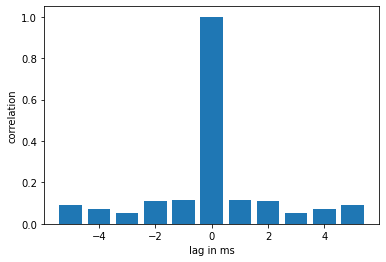

In [21]:
unit_a = 2
unit_b = 2
# crosscorrs_units[unit_a][unit_b] 
crosscorrs_units = crosscorr(units_data[unit_a]['timestamps'],
                             units_data[unit_b]['timestamps'])

plt.bar(lag_bins_ms, crosscorrs_units)
plt.xlabel('lag in ms')
plt.ylabel('correlation');

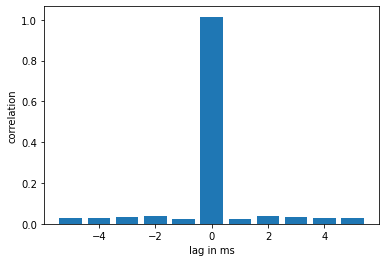

In [22]:
# execute funtions
# ts_example = np.sort(unit_mat['Unit'][0][COL][TS][0])

UNIT = 1
autocorrs_units = dict()
autocorrs_units[UNIT] = autocorr(units_data[UNIT]['timestamps'])

plt.bar(lag_bins_ms, autocorrs_units[UNIT])
plt.xlabel('lag in ms')
plt.ylabel('correlation');

# Grid plots
Showing multiple units for each experiment

In [23]:
def make_grid_array(num_units):
    """takes any number of units >3 and returns an array of indices
    for ploting a grid of units
    """
    max_cols = 4
    x=np.arange(num_units)
    dim2 = min(int(np.floor(np.sqrt(num_units))), max_cols)
    dim1 = int(np.ceil(num_units / dim2))
    x.resize(dim1*dim2)
    x.shape
    return x.reshape(dim1,dim2)

grid_arr = make_grid_array(5)
print(grid_arr.shape)
grid_arr

(3, 2)


array([[0, 1],
       [2, 3],
       [4, 0]])

Grid plot of experiment timecourse

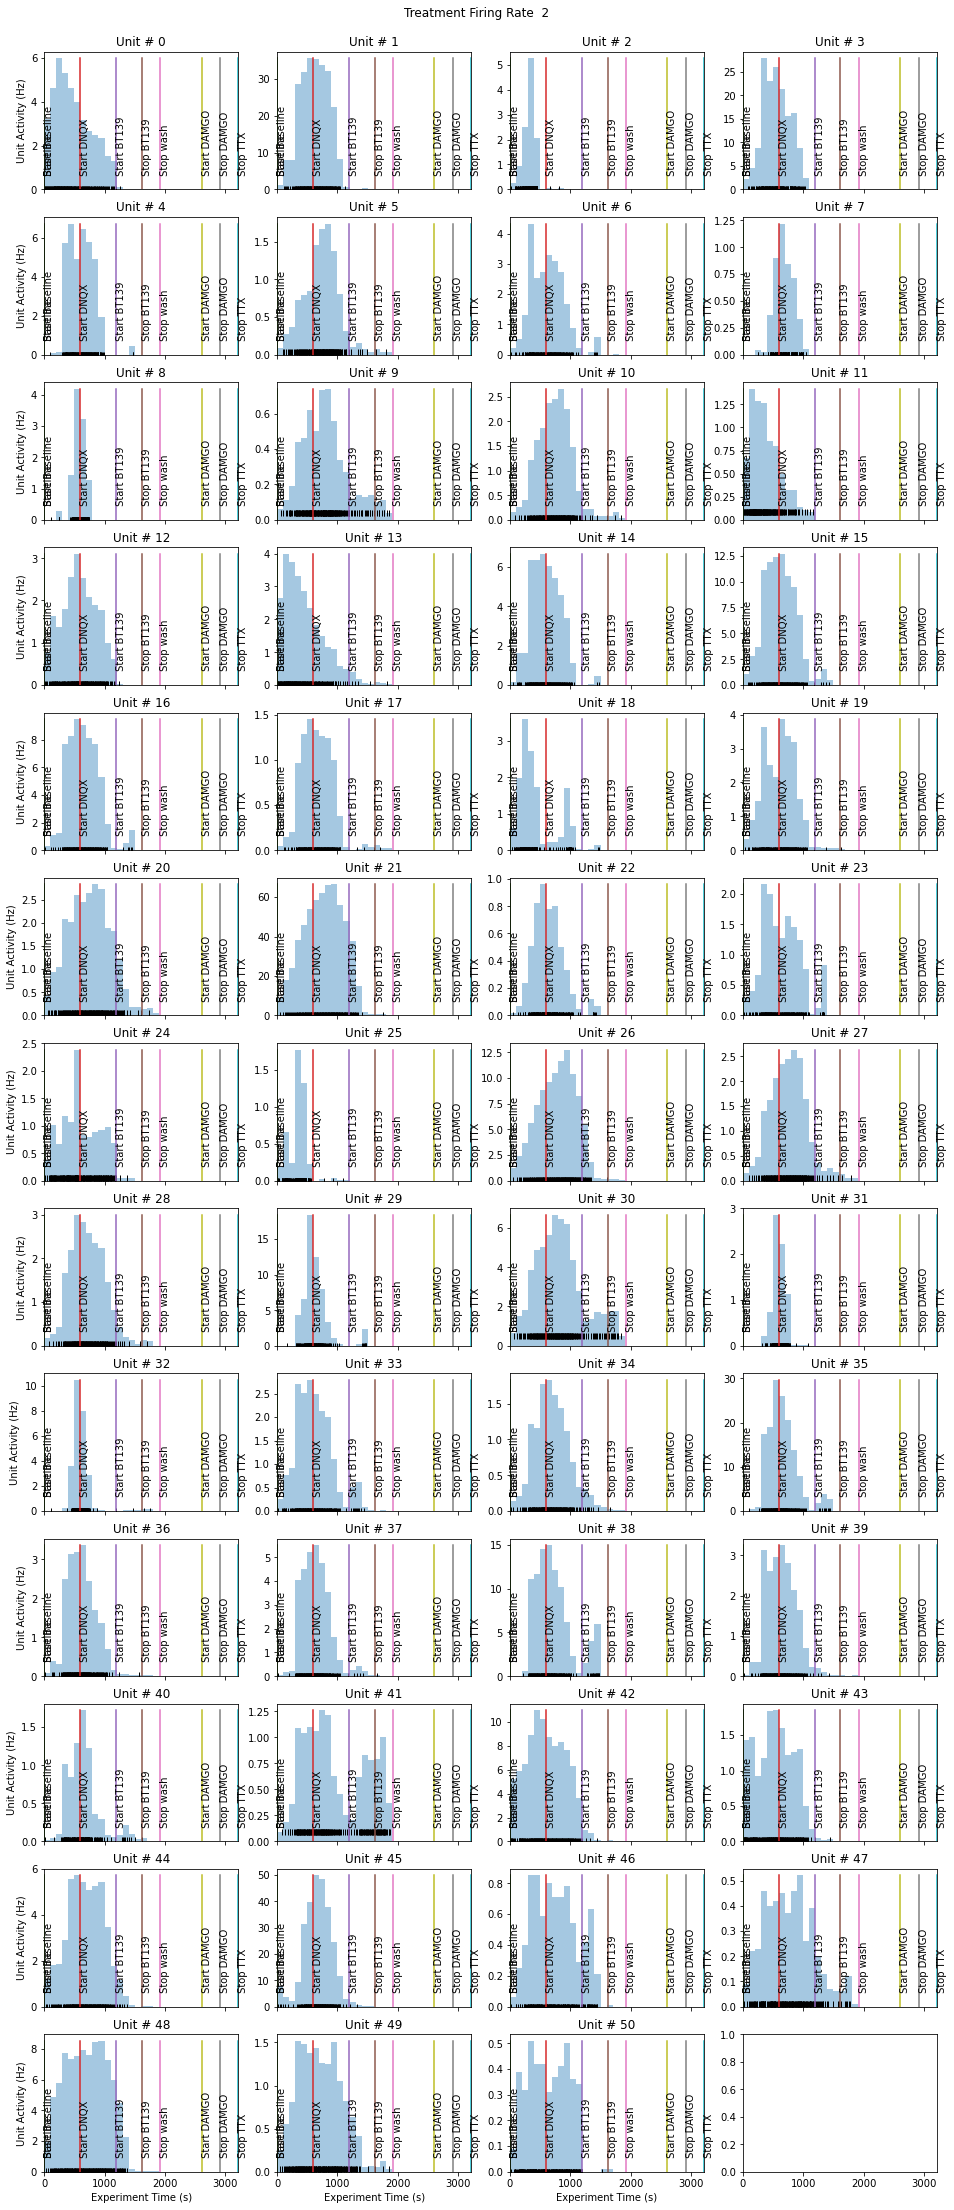

In [24]:
def hist_subplot(units_data, unit, tx_times, bin_sec, row, col, axs1, axs2, nrows, ncols):
    timestamps = units_data[unit]['timestamps']

    num_ts = timestamps.shape[0]
    bins = get_hist_bins(timestamps, bin_sec)
    max_tx = max(tx_times.values())

    # plot hist
    # N is the count in each bin, bins is the lower-limit of the bin
    counts, bin_edges = np.histogram(timestamps, bins=bins)
    N, bins, patches = axs1[row, col].hist(bins[:-1], bins=bins, weights=(counts/bin_sec), alpha=0.4)

    # plot rug
    thin_rug = rug_thinning_factor(num_ts) # improves visualization, make func
    rug_height = N.min()
    axs1[row, col].plot(timestamps[::thin_rug], [rug_height]*len(timestamps[::thin_rug]), '|', color='k');

    # plot treatment boundary times
    y_span = np.linspace(0, N.max(), num=2)
    
    for tx, tx_time in tx_times.items():
        axs1[row, col].plot((tx_time * np.ones(2)), y_span)
        axs1[row, col].annotate(tx, (tx_time, (N.max()*0.1)), rotation=90)

    plt.xlim(0, max_tx)

    axs1[row, col].set_title('Unit # ' + str(unit)) 
    if col == 0:
        axs1[row, col].set_ylabel('Unit Activity (Hz)')
    if row == (nrows-1):
        axs1[row, col].set_xlabel('Experiment Time (s)')

def plot_hist_grid(units_data, tx_times, bin_sec, num_units):
    grid_array = make_grid_array(num_units)
    nrows, ncols = grid_array.shape

    fig, axs1 = plt.subplots(*grid_array.shape, sharex='all', figsize=(ncols*4,nrows*3))
    axs2 = axs1 

    for row, cols in enumerate(grid_array):
        for col, unit in enumerate(cols):
            if not (unit == 0 and col != 0):
                hist_subplot(units_data, unit, tx_times, bin_sec, row, col, axs1, axs2, nrows, ncols)
    return fig
            
# set experiment info    
expt_id = expt_list[0]
units_data, tx_times = get_expt_data(unit_filename, tx_filename)
num_units = len(units_data.keys())
bin_sec = 100

fig = plot_hist_grid(units_data, tx_times, bin_sec, num_units)
grid_array = make_grid_array(num_units)
nrows, ncols = grid_array.shape
plt.suptitle('Treatment Firing Rate  ' + expt_id, y=(1 - 0.008*nrows));

plt.show()

In [25]:
# PRODUCT_DIR = '/Users/walter/Data/med64/product/HB_139_DAMGO/'
save_filename = PRODUCT_DIR + r'timecourse_hist\\' + r'timecourse_hist_' + expt_id
fig.savefig(save_filename, dpi=150)

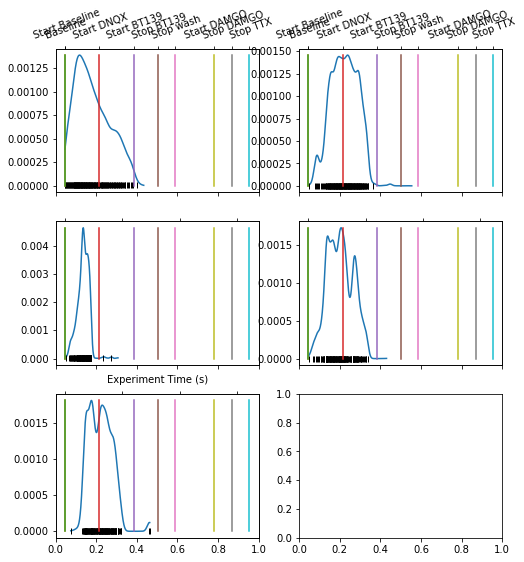

In [26]:
expt_num = 0
expt_id = expt_list[expt_num]

tx_times = read_tx_file(tx_filename)
units_data = read_units_file(unit_filename)

### make plot

num_units = 5 #len(units_data.keys())
grid_array = make_grid_array(num_units)
nrows, ncols = grid_array.shape

fig, axs1 = plt.subplots(*grid_array.shape, sharex='all', figsize=(ncols*4,nrows*3))
axs2 = axs1 

for row, cols in enumerate(grid_array):
    for col, unit in enumerate(cols):
        if not (unit == 0 and col != 0):
            
            timestamps = units_data[unit]['timestamps']

            num_ts = timestamps.shape[0]

            # create function for density
            density = stats.kde.gaussian_kde(timestamps)

            # plot kernel density
            x = np.arange(timestamps.min(), timestamps.max(), 0.1)
            kde_x = density(x)
            axs2[row, col] = axs1[row, col].twiny()
            axs1[row, col].plot(x, kde_x)

            # plot rug
            thin_rug = rug_thinning_factor(num_ts) # improves visualization, make func
            rug_height = kde_x.min()
            axs1[row, col].plot(timestamps[::thin_rug], [rug_height]*len(timestamps[::thin_rug]), '|', color='k');

            # plot treatment boundary times
            density_range = np.linspace(0, kde_x.max(), num=2)

            for tx, tx_time in tx_times.items():
                axs2[row, col].plot((tx_time * np.ones(2)), density_range)
                axs2[row, col].set_xticklabels([]);

            if col == 0:
                axs1[row, col].set_ylabel('Unit Activity KDE')
            if row == (nrows-1):
                axs1[row, col].set_xlabel('Experiment Time (s)')
            if row == 0:
                axs2[row, col].set_xticks(list(tx_times.values()))
                axs2[row, col].set_xticklabels(list(tx_times.keys()), rotation=20);



In [27]:
save_filename = PRODUCT_DIR + r'timecourse_hist\\' + r'timecourse_' + expt_id
fig.savefig(save_filename, dpi=150)

## Plot array of auto-correlograms ##

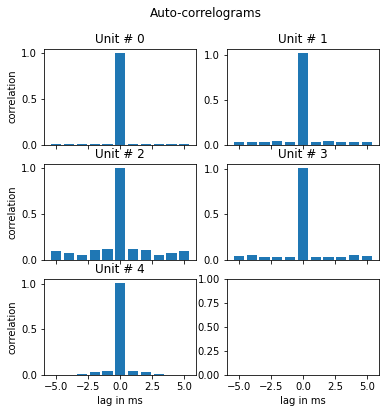

In [28]:
# works for min of 4 plots

# AUTO-CORRELOGRAM
num_units = 5 #len(units_data.keys())
grid_array = make_grid_array(num_units)
nrows, ncols = grid_array.shape

autocorrs_units = dict()

fig, axs = plt.subplots(*grid_array.shape, sharex='all', figsize=(ncols*3,nrows*2))

for row, cols in enumerate(grid_array):
    for col, unit in enumerate(cols):
        if not (unit == 0 and col != 0):
            autocorrs_units[unit] = autocorr(units_data[unit]['timestamps'])
            axs[row, col].bar(lag_bins_ms, autocorrs_units[unit])      
            axs[row, col].set_title('Unit # ' + str(unit)) 
        if row == (nrows-1):
            axs[row, col].set_xlabel('lag in ms')
        if col == 0:
            axs[row, col].set_ylabel('correlation')
plt.suptitle('Auto-correlograms', y=(1 - 0.008*nrows));


## Plot array of cross-correlograms ##

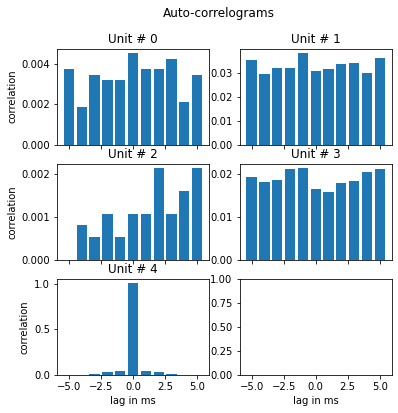

In [29]:
# CROSS
reference_unit = 4

num_units = 5 #len(units_data.keys())
grid_array = make_grid_array(num_units)
nrows, ncols = grid_array.shape

crosscorrs_units = dict()

fig, axs = plt.subplots(*grid_array.shape, sharex='all', figsize=(ncols*3,nrows*2))

for row, cols in enumerate(grid_array):
    for col, unit in enumerate(cols):
        if not (unit == 0 and col != 0):
            crosscorrs_units[unit] = crosscorr(units_data[reference_unit]['timestamps'],
                                         units_data[unit]['timestamps'])
            axs[row, col].bar(lag_bins_ms, crosscorrs_units[unit])     
            axs[row, col].set_title('Unit # ' + str(unit)) 
        if row == (nrows-1):
            axs[row, col].set_xlabel('lag in ms')
        if col == 0:
            axs[row, col].set_ylabel('correlation')
plt.suptitle('Auto-correlograms', y=(1 - 0.008*nrows));


## Plot array of waveforms ##

<AxesSubplot:>

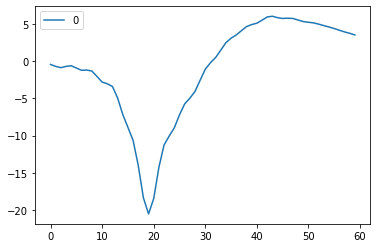

In [30]:
UNIT = 19
sns.lineplot(data = units_data[UNIT]['waveform'])


## plot arrays of waveforms ##

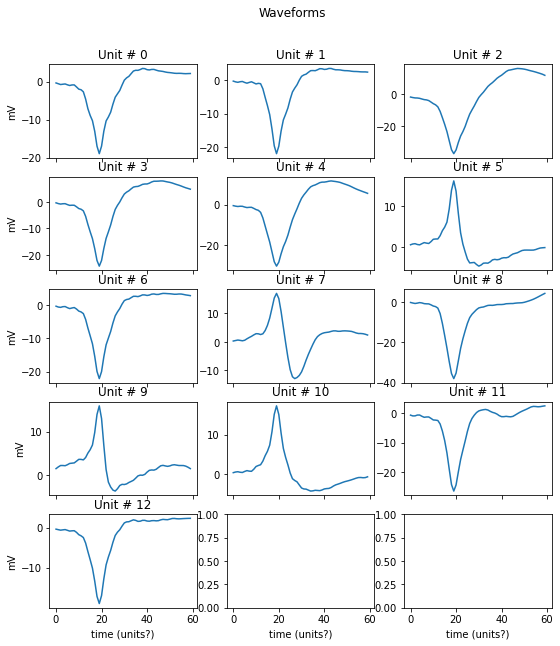

In [31]:
# works for min of 4 plots

num_units = 13 # len(units_data.keys())
grid_array = make_grid_array(num_units)
nrows, ncols = grid_array.shape


fig, axs = plt.subplots(*grid_array.shape, sharex='all', figsize=(ncols*3,nrows*2))

for row, cols in enumerate(grid_array):
    for col, unit in enumerate(cols):
        if not (unit == 0 and col != 0):
            axs[row, col].plot(units_data[unit]['waveform'])
            axs[row, col].set_title('Unit # ' + str(unit)) #text(0,0, ('Unit # ' + str(unit))
        if row == (nrows-1):
            axs[row, col].set_xlabel('time (units?)')
        if col == 0:
            axs[row, col].set_ylabel('mV')
plt.suptitle('Waveforms', y=(1 - 0.008*nrows));
